# 고양이가 되고 싶어요!
얼굴에 고양이 스티커 필터 적용하기
- 이미지에서 사람의 얼굴 위치 탐지
- 얼굴에 특징점(Landmarks) 탐지
- 특징점을 이용해 스티커 적용 위치 설정
- 고양이 스티커 적용

## 특이사항
- 얼굴 탐지에 실패할 시 이미지 사이즈 재조정(4:3, 16:9 비율)
- **각도에 따른 스티커 회전 처리 후 적용**
- **각도에 따른 스티커 원근법 처리 후 적용**

> 모든 사진에 동일하게 적용되도록 하기 위해 **비율**을 이용해 모든 좌표를 계산했다.
<hr>

# 목차

### 기본 파이프라인
1. 이미지 불러오기 및 시각화
2. 이미지 내에 얼굴 탐지
3. 얼굴 내에 특징점(Landmarks) 추출
4. 특징점을 바탕으로 스티커 적용(Test)

### 보정에 따른 특수효과 적용
이미지 각도에 따른 보정 실시
1. 스티커 회전 적용
  - 특징점을 바탕으로 회전 각도 계산
  - 계산된 각도 만큼 스티커 회전 적용
2. 스티커 원근법 적용
  - 코와 양쪽 턱 사이의 거리로 원근감 계산
  - 원근감을 바탕으로 보정 적용
<hr>

In [1]:
import os

import dlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import cv2

from PIL import Image

pont_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname=pont_path, size=18)

# 이미지 불러오기 및 시각화

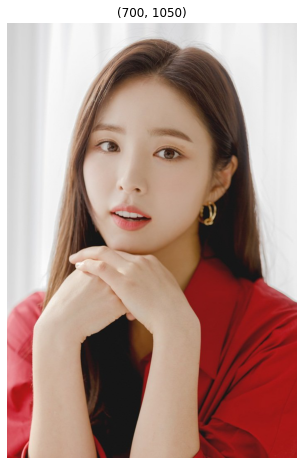

In [2]:
image_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/image.png'
image = Image.open(image_path)

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title(image.size)
plt.axis('off')
plt.show()

# 이미지 얼굴부분 탐지
- 원본 이미지를 적용하여 최종 결과물에 스티커 적용
> **탐지 실패 시 여러 비율로 이미지 사이즈를 변경하여 얼굴 탐지**


rectangles[[(118, 204) (504, 590)]]


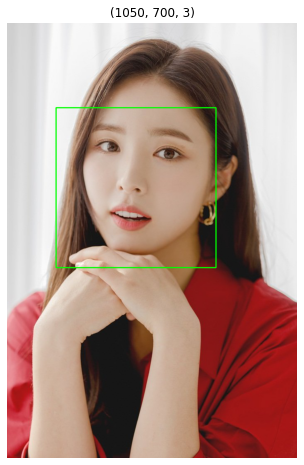

In [3]:
image = np.array(image)
image_show = image.copy() # 원본 이미지 저장

detector_hog = dlib.get_frontal_face_detector() # 얼굴 탐지기 불러오기
face_detection = detector_hog(image, 1)         # 얼굴 탐지 실시

print(face_detection) # 탐지 결과

# 탐지된 얼굴 시각화
for rect in face_detection:
    left = rect.left()
    top = rect.top()
    right = rect.right()
    bottom = rect.bottom()

    cv2.rectangle(image, (left, top), (right, bottom), (0,255,0), 2) # 상자 그리기(얼굴 탐지)

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title(image.shape)
plt.axis('off')
plt.show()

# 특징점(Landmarks) 추출
- 이미 학습된 특징점 추출기를 활용
- 탐지한 얼굴을 활용해 특징점 추출
> **이후 분석에 활용하기 위해 각 특징점의 위치를 번호로 표기**

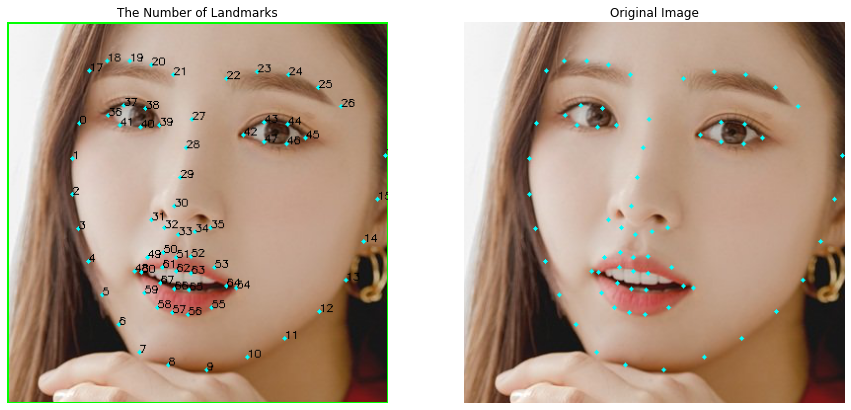

In [4]:
# 학습된 추출기의 feature 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) # feature 적용

landmark_image = image.copy()
original_image = image_show.copy()
points = landmark_predictor(image, face_detection[0]) # 탐지한 얼굴 부분을 활용해 특징점 추출
landmarks = list(map(lambda p: (p.x, p.y), points.parts()))

# 번호 표기를 위해 각 특징점의 index 출력(== 특징점의 번호)
for number, landmark in enumerate(landmarks):
    cv2.circle(original_image, landmark, 2, (0, 255, 255), -1)
    cv2.circle(landmark_image, landmark, 2, (0, 255, 255), -1)
    cv2.putText(landmark_image, str(number), landmark, fontScale=0.35, color=(0,0,0), # 특징점 번호 표기
                fontFace = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX)                         # 폰트 및 폰트 사이즈 설정
    
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(landmark_image[top:top+(bottom-top),left:left+(right-left)])
plt.title('The Number of Landmarks')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(original_image[top:top+(bottom-top),left:left+(right-left)])
plt.title('Original Image')
plt.axis('off')

plt.show()

# 스티커 사진 불러오기
- 노드에서 제공해준 사진 이용
- 투명도는 사용하지 않음
- 얼굴 이미지에 맞게 스티커 이미지 사이즈 변경
> - **원근감 보정 시 수염이 짤리는 문제를 해결하기 위해 사진 상하좌우에 padding추가**<br>
> - **상하좌우에 padding(빈 공간) 80~100개 정도 추가**

### Padding 적용 시 주의할 점
- 100을 추가했지만 실제로는 100보다 적은 이유는 추가한 이후에 다시 resize를 했기 때문이다.
- Resize를 한 후에 Padding을 적용하면 이후에 있을 분석에 악영향을 미침
> 이후에 있을 분석은 전부 Width와 Height의 **비율**로 값들이 결정되는데,<br>
Resize를 먼저 적용한 후 Padding을 추가하면 이미지의 사이즈가 변할때마다 **수염의 비율**이 달라짐

(322, 322)


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


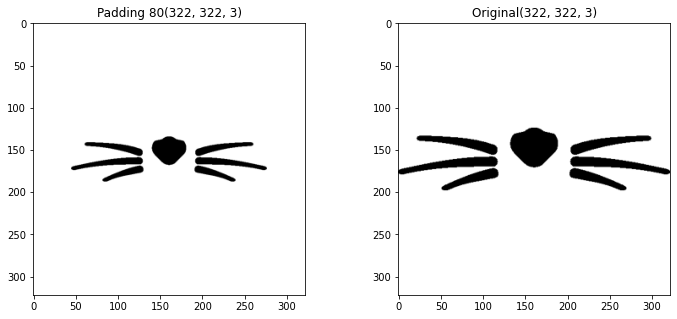

In [5]:
sticker_size = (int(rect.width() // 1.2), int(rect.height() // 1.2)) # 스티커 이미지 사이즈 조정
print(sticker_size)
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/cat-whiskers.png'
sticker = Image.open(sticker_path).convert('RGB')
sticker_original = np.array(sticker.resize(sticker_size)).copy() # 비교를 위해 이미지 원본 저장

# Padding 100 추가 / 빈 공간은 흰색(value=255)으로 설정 / value 값으로 동일하게 추가(BORDER_CONSTANT)
sticker = cv2.copyMakeBorder(np.array(sticker), 100, 100, 100, 100, cv2.BORDER_CONSTANT,value=[255,255,255])
sticker = np.array(Image.fromarray(sticker).resize(sticker_size))

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.imshow(sticker)
plt.title(f'Padding 100{sticker.shape}')

plt.subplot(1,2,2)
plt.imshow(sticker_original)
plt.title(f'Original{sticker_original.shape}')

plt.show()

## 특징점별 좌표값 확인
- ```nose``` : 얼굴 이미지에서 코의 좌표
  - 특징점(Landmarks) 중 30번 째 Point
- ```Sticker``` : 얼굴 이미지에서 스티커 이미지의 좌상단 좌표
  - nose좌표에서 스티커 가로,세로 길이의 절반 값만큼 좌,상으로 이동

nose x y:  287 390
sticker x y:  126 229
sticker size : 322 322


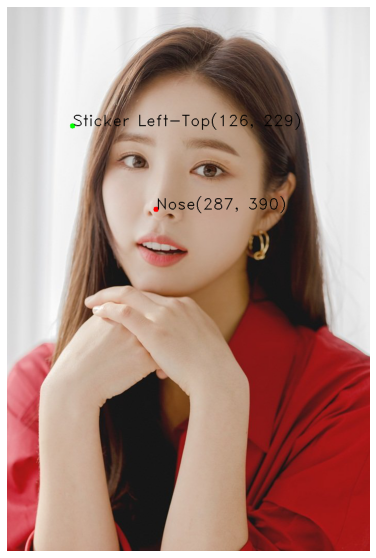

In [6]:
# landamarks 중 30번 째 Point
nose_x = landmarks[30][0]
nose_y = landmarks[30][1]

# 스티커 이미지의 가세, 세로 길이 계산
sticker_width = sticker_size[0]
sticker_height = sticker_size[1]

# nose좌표를 기준으로 스티커의 가로,세로의 절반 값 만큼 좌,상으로 이동
sticker_x = nose_x - (sticker_width // 2)
sticker_y = nose_y - (sticker_height // 2)

print('nose x y: ', nose_x, nose_y)
print('sticker x y: ', sticker_x, sticker_y)
print('sticker size :', sticker_width, sticker_height)

example_image = image_show.copy()
cv2.circle(example_image, (nose_x, nose_y), 5, (255,0,0), -1)
cv2.circle(example_image, (sticker_x, sticker_y), 5, (0,255,0), -1)
cv2.putText(example_image, f'Nose{(nose_x,nose_y)}', (nose_x, nose_y), fontScale=1, color=(0,0,0),
                fontFace = cv2.FONT_HERSHEY_DUPLEX )
cv2.putText(example_image, f'Sticker Left-Top{(sticker_x,sticker_y)}', (sticker_x, sticker_y), fontScale=1, color=(0,0,0),
                fontFace = cv2.FONT_HERSHEY_DUPLEX ) 

plt.figure(figsize=(10,10))
plt.imshow(example_image)
plt.axis('off')
plt.show()

# 스티커 사진 적용
- 코 좌표(nose)
> **회전 및 원근감 보정 없이 일반적인 경우**

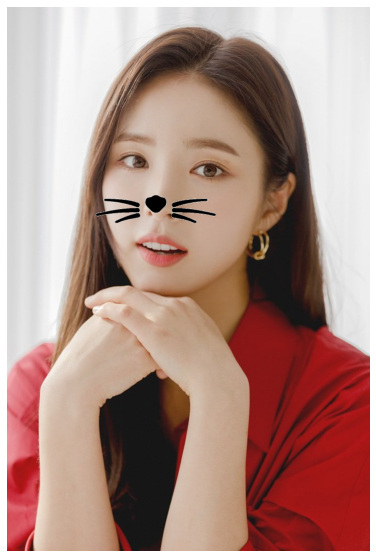

In [7]:
normal_image = image_show.copy()
sticker_area = normal_image[sticker_y:sticker_y + sticker_height,
                             sticker_x:sticker_x + sticker_width]

normal_image[sticker_y:sticker_y + sticker_height, 
              sticker_x:sticker_x + sticker_width] = np.where(sticker==255, sticker_area, sticker)

plt.figure(figsize=(10,10))
plt.imshow(normal_image)
plt.axis('off')
plt.show()

# 스티커 사진 보정

## 특수효과1 : 회전 보정
얼굴 각도에 따른 회전 각도를 계산해 보정

1. Landmark 0번과 16번을 이용해 **얼굴의 회전 각도**를 계산
2. ```GetRotationMatrix2D```함수에 각도를 대입해 **회전 Matrix** 계산
3. 회전 Matrix를 스티커 이미지에 적용하여 스티커 회전
>**이미지의 경우 밑으로 갈수록 양수이기 때문에 y대칭 적용**

<hr>

![tetawet](images/rotation-explain.jpg)

### 얼굴의 회전 각도

In [8]:
import math

x1, y1 = landmarks[0][0], landmarks[0][1] # Landmark 0번
x2, y2 = landmarks[16][0], landmarks[16][1] # Landmark 16번
dx, dy = (x2 - x1),  -(y2 - y1) # y대칭 적용
theta = math.atan2(dy, dx) 
print(f'{theta:0.4f} radian / {np.degrees(theta):0.4f} degree' )

-0.1061 radian / -6.0763 degree


### 회전 Matrix 및 적용

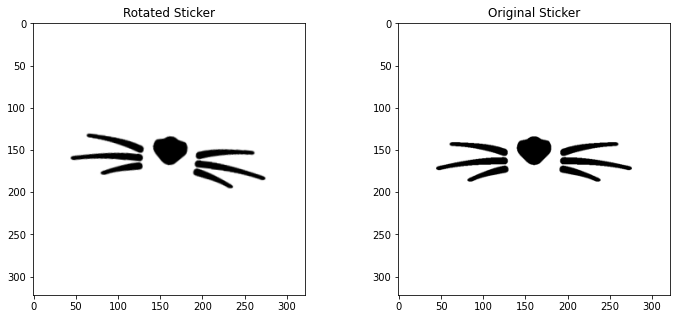

In [9]:
matrix_rotation = cv2.getRotationMatrix2D((sticker_size[0]//2, sticker_size[1]//2), np.degrees(theta), 1)
rotated_sticker = cv2.warpAffine(sticker, matrix_rotation, 
                                (sticker_size[0], sticker_size[1]), 
                                 borderValue = [255, 255, 255, 255])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(rotated_sticker)
plt.title('Rotated Sticker')

plt.subplot(1,2,2)
plt.imshow(sticker)
plt.title('Original Sticker')

plt.show()
# rotated_sticker = rotate(sticker, (np.degrees(theta)), mode='constant', cval=255)
# rotated_sticker = np.array(Image.fromarray(rotated_sticker).resize(sticker_size))
# plt.imshow(rotated_sticker)

### 회전된 스티커 적용

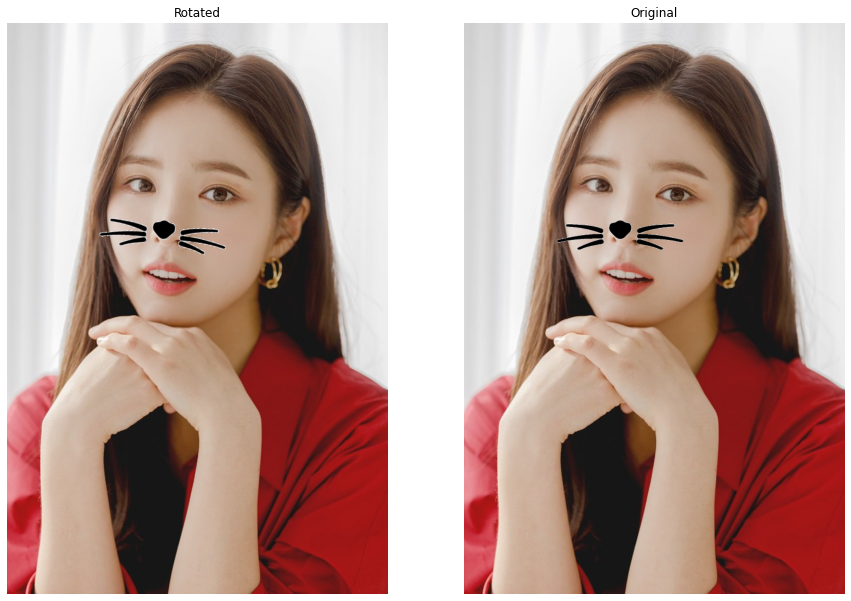

In [10]:
rotated_image = image_show.copy()
sticker_area = rotated_image[sticker_y:sticker_y + sticker_height,
                       sticker_x:sticker_x + sticker_width]

rotated_image[sticker_y:sticker_y + sticker_height, 
              sticker_x:sticker_x + sticker_width] = np.where(rotated_sticker==255, sticker_area, rotated_sticker)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1), plt.imshow(rotated_image), plt.axis('off'), plt.title('Rotated')
plt.subplot(1,2,2), plt.imshow(normal_image), plt.axis('off'), plt.title('Original')
plt.show()

## 특수효과2 : 원근법 보정
얼굴 각도에 따른 원근감을 계산해 보정
> 원본 스티커 이미지를 **보정된 좌표**로 변환하는 방법 - ```getPerspectiveTransform``` 활용

![perspective-example.jpg](images/perspective-example.jpg)

## 원근법 보정 과정
1. 고양이 코 2개의 중심(sticker_center_up,down)와 수염 끝 부분(whisker1, whisker3) 좌표 추출<font color='green'>(초록색)</font>
2. 변환하고자 하는 2개의 점(new_place1, new_place3) 좌표 추출<font color='red'>(빨간색)</font>
3. 초록색 좌표를 빨간색 좌표로 <u>**Perspective Transform**</u> 적용
> **Perspective Transform적용 시 4개의 점이 필요한데, 고양이 코 중심 2개의 좌표는 변환 전과 후 모두 동일하게 사용**

### 고양이 코 중심과 수염 끝 부분 좌표 추출
모든 사이즈의 이미지에 적용될 수 있도록 **가로,세로의 비율**을 통해 좌표 추출
- 복잡한 과정이 있기 때문에 **함수**로 작성해서 사용
- ```get_sticker_center()``` : 고양이 코 중심 구하는 함수(위, 아래 2개) - **Perspective Transform적용 시 필요한 좌표**
- ```get_whisker_point()``` : 고양이 오른쪽 수염 끝부분 3개의 좌표 구하는 함수
- ```rotate_point()``` : Rotated된 스티커 이미지와 동일한 각도로 점 좌표를 회전시키는 함수
- ```sticker_x_y``` : 얼굴 이미지에 맞게 설정된 Sticker의 좌상단 좌표
> **스티커 이미지가 Rotated되어있기 때문에 모든 점에 대해서도 Rotate를 적용해야 한다.**

In [11]:
import math

# Rotated된 스티커와 동일한 각도로 좌표 회전시키는 함수
def rotate_point(point, radians, origin=(0, 0)):
    x, y = point        # 바꾸려는 좌표
    ox, oy = origin     # 회전 시 기준이 되었던 좌표(sticker 이미지의 중심) != 고양이 코

    qx = ox + math.cos(radians) * (x - ox) + math.sin(radians) * (y - oy)
    qy = oy + -math.sin(radians) * (x - ox) + math.cos(radians) * (y - oy)

    return int(qx), int(qy)

# 고양이 코 중심 좌표 구하는 함수(위, 아래 좌표)
def get_sticker_center(sticker_x_y, sticker_size, theta=theta):
    sticker_x, sticker_y = sticker_x_y     # 얼굴 이미지에서 sticker의 좌상단 좌표
    
    sticker_center_up_origin = (sticker_size[0] * 0.5, sticker_size[1] * 0.44)     # 스티커에서 고양이 코 위 좌표(비율)
    sticker_center_down_origin = (sticker_size[0] * 0.5, sticker_size[1] * 0.52)   # 스티커에서 고양이 코 아래 좌표(비율)
    
    # 고양이 코 중심 2개 좌표(위, 아래) Rotated 적용(위에서 정의한 rotate_point 함수 사용)
    sticker_c_up_rotated = rotate_point(sticker_center_up_origin, theta, origin=(sticker_size[0]//2, sticker_size[1]//2)) 
    sticker_c_down_rotated = rotate_point(sticker_center_down_origin, theta, origin=(sticker_size[0]//2, sticker_size[1]//2))
    
    # 스티커 이미지의 좌표를 얼굴 이미지의 좌표로 변환
    sticker_center_up = (sticker_x + int(sticker_c_up_rotated[0]), sticker_y + int(sticker_c_up_rotated[1]))
    sticker_center_down = (sticker_x + int(sticker_center_down_origin[0]), sticker_y + int(sticker_center_down_origin[1]))
    
    return sticker_center_up, sticker_center_down

# 양이 스티커의 수엽 끝 부분 구하는 함수(오른쪽 3개)
def get_whisker_point(sticker_x_y, sticker_size, theta=theta):
    sticker_x, sticker_y = sticker_x_y     # 얼굴 이미지에서 sticker의 좌상단 좌표
    
    whisker1_origin = (sticker_size[0] * 0.81, sticker_size[1] * 0.44)   # 스티커에서 고양이 수염 끝부분(위)
    whisker2_origin = (sticker_size[0] * 0.86, sticker_size[1] * 0.53)   # 스티커에서 고양이 수염 끝부분(중간)
    whisker3_origin = (sticker_size[0] * 0.74, sticker_size[1] * 0.58)   # 스티커에서 고양이 수염 끝부분(아래)
    
    # 고양이 수염 끝 부분 좌표(위,중심,아래) Rotated 적용(위에서 정의한 rotate_point 함수 사용)
    whisker1_rotated = rotate_point(whisker1_origin, theta, origin=(sticker_size[0]//2, sticker_size[1]//2)) # origin
    whisker2_rotated = rotate_point(whisker2_origin, theta, origin=(sticker_size[0]//2, sticker_size[1]//2)) # == 스티커 중심 좌표
    whisker3_rotated = rotate_point(whisker3_origin, theta, origin=(sticker_size[0]//2, sticker_size[1]//2))
    
    # 스티커 이미지의 좌표를 얼굴 이미지의 좌표로 변환
    whisker1 = (sticker_x + int(whisker1_rotated[0]), sticker_y + int(whisker1_rotated[1]))
    whisker2 = (sticker_x + int(whisker2_rotated[0]), sticker_y + int(whisker2_rotated[1]))
    whisker3 = (sticker_x + int(whisker3_rotated[0]), sticker_y + int(whisker3_rotated[1]))
    
    return whisker1, whisker2, whisker3

### 좌표 예시

Text(0.5, 1.0, 'Whisker & Nose Center')

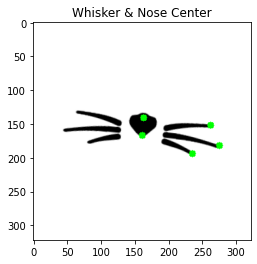

In [12]:
w1, w2, w3 = get_whisker_point((0, 0), sticker_size)
center_up, center_down = get_sticker_center((0, 0), sticker_size)

example_sticker = rotated_sticker.copy()
cv2.circle(example_sticker, (w1[0], w1[1]), 5, (0,255,0), -1)
cv2.circle(example_sticker, (w2[0], w2[1]), 5, (0,255,0), -1)
cv2.circle(example_sticker, (w3[0], w3[1]), 5, (0,255,0), -1)
cv2.circle(example_sticker, (center_up[0], center_up[1]), 5, (0,255,0), -1)
cv2.circle(example_sticker, (center_down[0], center_down[1]), 5, (0,255,0), -1)

plt.imshow(example_sticker)
plt.title('Whisker & Nose Center')

### Perspective Transform을 적용할 좌표 추출
모든 사진에 적용될 수 있도록 **특별한 기준**을 통해 새로운 좌표(dt) 추출<br>
> **기준** <br>
landmark 30번(코)에서  Landmark 15~13번(턱)까지의 거리에서 각각 **0.8**이 되는 지점(dt == new_place)<br>
수염마다 길이가 다르기 때문에 상대적으로 짧은 수염인 위(w1), 아래(w3) 수염은 전체 길이에 0.8을 추가로 적용

![get-point.png](images/get-point.png)
### 두 좌표(landmark 13~15, 30)와 원하는 길이(dt)를 통해 새로운 좌표를 구하는 공식

(-0.5, 699.5, 1049.5, -0.5)

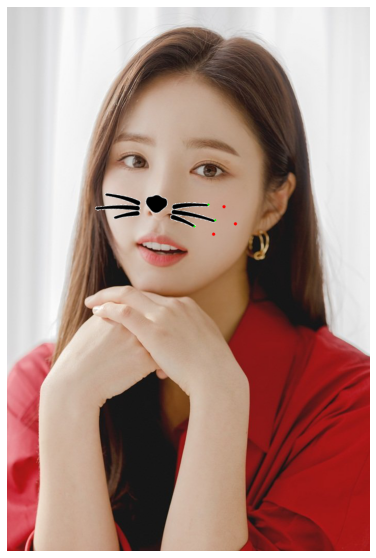

In [13]:
# 수염 끝 부분 추출(오른쪽 3개)
whisker1, whisker2, whisker3 = get_whisker_point((sticker_x, sticker_y), sticker_size)
nose = (nose_x, nose_y) # landmark 30번 좌표(코)

#d = np.linalg.norm(np.array(landmarks[15]) - np.array(whisker1))
d = np.linalg.norm(np.array(landmarks[15]) - np.array(nose)) # 코와 턱 사이의 길이
dt = 0.8 * d  # 코와 (새로운 좌표가 있으면 하는 좌표)까지의 길이

# 각 수염별로 새로운 좌표 추출
# 1번과 3번 수염의 경우 2번 수염보다 짧기 때문에 0.8 적용
new_place1 = (dt * 0.8)  * ((np.array(landmarks[15]) - np.array(nose)) / d) + np.array(nose) 
new_place2 = dt * ((np.array(landmarks[14]) - np.array(nose)) / d) + np.array(nose)
new_place3 = (dt * 0.8) * ((np.array(landmarks[13]) - np.array(nose)) / d) + np.array(nose)

# 시각화
example_image = rotated_image.copy()
cv2.circle(example_image, (whisker1[0], whisker1[1]), 2, (0,255,0), -1)
cv2.circle(example_image, (whisker2[0], whisker2[1]), 2, (0,255,0), -1)
cv2.circle(example_image, (whisker3[0], whisker3[1]), 2, (0,255,0), -1)
cv2.circle(example_image, (int(new_place1[0]), int(new_place1[1])), 3, (255,0,0), -1)
cv2.circle(example_image, (int(new_place2[0]), int(new_place2[1])), 3, (255,0,0), -1)
cv2.circle(example_image, (int(new_place3[0]), int(new_place3[1])), 3, (255,0,0), -1)

plt.figure(figsize=(10,10))
plt.imshow(example_image)
plt.axis('off')

## 새로운 좌표로 스티커 이미지 변환하기(Perspective Transform)
> **얼굴 이미지에 바로 변환을 적용하면 얼굴까지 적용이 되기 때문에<br>
스티커 이미지에 적용을 한 후에 다시 얼굴 이미지에 적용한다.**

- Perspective Transform을 하고자 하는 좌표(new_place)는 얼굴 이미지에서 추출한 좌표
- 스티커 이미지에만 따로 적용하기 위해 증가한 **비율(whisker_to_new_ratio)**을 계산해 스티커 이미지에 적용
- 변환하는데 필요한 좌표는 4개 뿐이기에 3개의 수염 중 위, 아래(whisker1, whisker3)만 사용

#### 스티커 이미지에 먼저 적용하기
> **문제점**<br>
수염의 경우 살짝 휘어진 모양을 하고 있다. 하지만 위에서 구한 변환되는 좌표(새로운 좌표)는 직선으로 구한 좌표이다.<br>
직선과 곡선의 차이를 보정하지 않으면 **원근감이 반대로 작용**하는 경우가 생기는 문제점이 있다.

![perspective-problem.jpg](images/perspective-problem.jpg)

### 해결방법
> 변환되는 좌표(새로운 좌표)의 y값에 **원근감**의 정도에 따라 **weight**값을 부여해 강제로 원근감을 부각시킨다.<br>
**얼굴의 왼쪽**과 **오른쪽**의 **길이의 차**를 이용해 원근감을 구하고, 결과에 따라 **weight**값을 더하거나 뺀다.
- 얼굴 왼쪽의 턱 좌표(Landmark 2번)와 오른쪽의 턱 좌표(Landmark 14)를 이용한다.
- 좌,우 턱 좌표와 코 좌표(Landmark 30)까지의 길이를 각각 구한다.
- 길이의 **비율(왼쪽/오른쪽)**을 이용해 특정 수치에 따라 weight값을 부여한다.(weight는 임의의 값)
  1. 비율이 0.7보다 낮으면 weight값만큼 y축을 감소시켜 오른쪽에서 본 모습을 강조
  2. 비율이 1.3다 높으면 weight값만큼 y축을 증가시켜 왼쪽에서 본 모습을 강조
  3. 비율이 0.7과 1.3사이라면 정면에서 본 것으로 간주하고 적용하지 않음

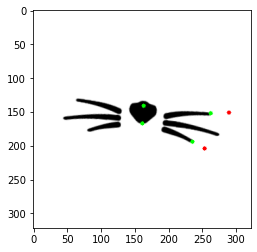

In [14]:
new_sticker = rotated_sticker.copy() # Rotated된 스티커 이미지의 원본 파손 방지

# 얼굴 이미지에서 기존 수염에서 늘어난 지점까지의 비율을 계산
whisker_to_new_ratio1 = np.array(new_place1) / np.array(whisker1) # 위 수염
whisker_to_new_ratio3 = np.array(new_place3) / np.array(whisker3) # 아래 수염

# 스티커 내에서 변환되기 전 수염의 좌표 구하기
whisker_in_sticker1, whisker_in_sticker2, whisker_in_sticker3 = get_whisker_point((0, 0), sticker_size)
sticker_center_up, sticker_center_down = get_sticker_center((0, 0), sticker_size)

########################################################################################################
# 원근감이 반대로 작용하는 문제 해결
left = (np.array(landmarks[30][0]) - np.array(landmarks[2][0]))     # 왼쪽 턱과 코까지의 길이
right = (np.array(landmarks[14][0]) - np.array(landmarks[30][0]))   # 오른쪽 턱과 코까지의 길이
ratio = left/right     # 왼쪽과 오른쪽 얼굴의 길이 비율                                  
if ratio < 0.7:
    weight = -0.04    # weight값(임의의 값)
elif ratio > 1.3:
    weight = 0.04      # weight값(임의의 값)
else:
    weight = 0         # weight값(임의의 값)

# 변환되는 좌표(새로운 좌표)에 weight값 적용
new_in_sticker1 = (whisker_in_sticker1 * (whisker_to_new_ratio3 + np.array([0, weight]))).astype(np.uint32)
new_in_sticker3 = (whisker_in_sticker3 * (whisker_to_new_ratio1 + np.array([0, -weight]))).astype(np.uint32)

# 결과 시각화
cv2.circle(new_sticker, (sticker_center_up[0], sticker_center_up[1]), 3, (0,255,0), -1)
cv2.circle(new_sticker, (sticker_center_down[0], sticker_center_down[1]), 3, (0,255,0), -1)
cv2.circle(new_sticker, (whisker_in_sticker1[0], whisker_in_sticker1[1]), 3, (0,255,0), -1)
cv2.circle(new_sticker, (whisker_in_sticker3[0], whisker_in_sticker3[1]), 3, (0,255,0), -1)

cv2.circle(new_sticker, (new_in_sticker1[0], new_in_sticker1[1]), 3, (255,0,0), -1)
cv2.circle(new_sticker, (new_in_sticker3[0], new_in_sticker3[1]), 3, (255,0,0), -1)

plt.imshow(new_sticker)

### Perspective Transform 적용

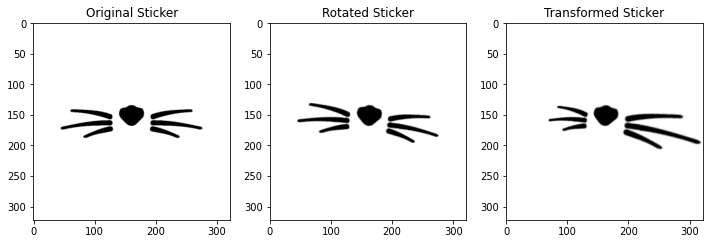

In [15]:
# 원본 이미지(rotated_sticker)에서의 좌표(고양이 코 위,아래 + 오른쪽 1,3번 수염)
src_p = np.float32([
    list(sticker_center_up),
    list(sticker_center_down),
    list(whisker_in_sticker3), 
    list(whisker_in_sticker1)])

# 변환되는 좌표(rotated_sticker)에서의 좌표(고양이 코 위,아래 + 오른쪽 1,3번 수염)
dst_p = np.float32([
    list(sticker_center_up),
    list(sticker_center_down),
    list(new_in_sticker3), 
    list(new_in_sticker1)])

# Perspective transform Matrix 구하기 및 적용
matrix_perspective = cv2.getPerspectiveTransform(src_p, dst_p)
trans_sticker = cv2.warpPerspective(rotated_sticker, matrix_perspective, 
                                    (rotated_sticker.shape[1], rotated_sticker.shape[0]), 
                                    borderValue = [255, 255, 255, 255])

plt.figure(figsize=(12,5))
plt.subplot(1,3,1), plt.imshow(sticker), plt.title('Original Sticker')
plt.subplot(1,3,2), plt.imshow(rotated_sticker), plt.title('Rotated Sticker')
plt.subplot(1,3,3), plt.imshow(trans_sticker), plt.title('Transformed Sticker')
plt.show()

# 변환된 사진 적용

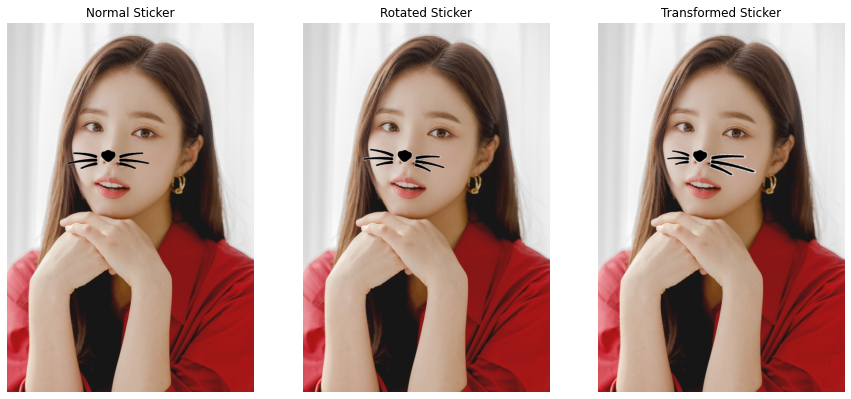

In [16]:
result = image_show.copy()

sticker_area = result[sticker_y:sticker_y + sticker_height,
                      sticker_x:sticker_x + sticker_width]
result[sticker_y:sticker_y + sticker_height, 
       sticker_x:sticker_x + sticker_width] = np.where(trans_sticker==255, sticker_area, trans_sticker)

plt.figure(figsize=(15,10))
plt.subplot(1,3,1), plt.imshow(normal_image), plt.axis('off'), plt.title('Normal Sticker')
plt.subplot(1,3,2), plt.imshow(rotated_image), plt.axis('off'), plt.title('Rotated Sticker')
plt.subplot(1,3,3), plt.imshow(result), plt.axis('off'), plt.title('Transformed Sticker')
plt.show()

# 결과 및 고찰
여러 사진에 대해 동일하게 적용하기 위해 최선의 노력을 했지만, 아쉽게도 한계가 있는 것 같다.
- 수염의 변환이 크면 잘리는 문제가 있다. 해결을 못 해서 너무 아쉽다.
- 변환이 되면 수염의 픽셀이 좀 깨지는 문제가 있다. 자연스럽지 못한 수염이 되는 것 같아서 아쉽다.
- Perspective Transform은 적용하지 말고 Rotation만 적용해도 충분히 이쁜 고양이 스티커가 적용되는 것 같다.
- 좌,우의 원근감을 정확히 계산할 수 없어서 수염의 확장 정도를 정확히 예측하기 힘들다.
- 얼굴 각도가 많이 틀어지면 한 쪽 면의 Landmark가 추출 불가능해서 위와 같은 효과를 적용하기는 힘들다.
![final.jpg](images/Final.jpg)

# 다양한 사진에 대한 결과

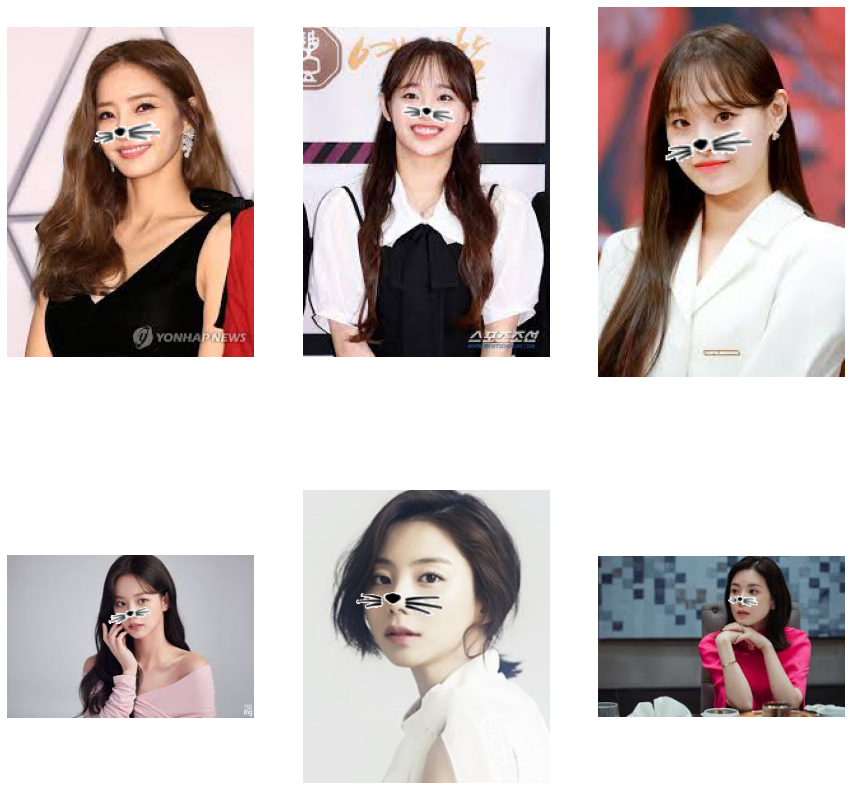

In [17]:
import glob
from Filter import cat_filter

image_list = glob.glob(os.getenv("HOME") + '/aiffel/example/*.png')

plt.figure(figsize=(15,15))
for i, image in enumerate(image_list):
    result = cat_filter(image)
    plt.subplot(2,3,i+1)
    plt.imshow(result)
    plt.axis('off')
    
plt.show()